# **Policy Gradient**

First of all let's import the required libraries:

In [1]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
import tensorflow as tf
import gymnasium as gym

from IPython.display import clear_output
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm import tqdm

In [2]:
# Show all figures in svg format
set_matplotlib_formats('svg')

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('animation', html='jshtml')
mpl.rcParams['animation.embed_limit'] = 2**128

In [3]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(tf.constant([obs], dtype=tf.float32))
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info, _ = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [4]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()[0]
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [5]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [6]:
# Define the environment
env = gym.make('Blackjack-v1', natural=False, sab=False, render_mode='rgb_array')

# Reset the environment
env.reset()

((13, 9, 0), {})

In [7]:
tf.keras.backend.clear_session()
n_inputs = [3]
n_outputs = 2

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy
# loss_fn = tf.keras.losses.mean_squared_error

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation="elu", input_shape=n_inputs),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
    # tf.keras.layers.Dense(n_outputs, activation="sigmoid"),
    # tf.keras.layers.Dense(n_outputs)
])

In [8]:
n_iterations = 5000
n_episodes_per_update = 32
n_max_steps = 100
discount_rate = 0.8

In [9]:
historic_rewards = []
mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print("\rIteration: {}/{}, mean reward: {:.1f}  ".format(iteration + 1, n_iterations, mean_reward), end="")
    
    for reward in all_rewards:
        historic_rewards.append(reward[0])

    mean_rewards.append(mean_reward)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 5000/5000, mean reward: -0.2  

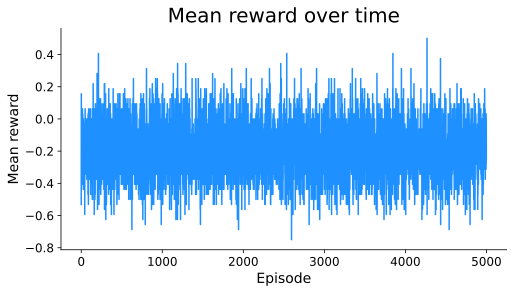

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(mean_rewards, color="dodgerblue")
plt.xlabel("Episode")
plt.ylabel("Mean reward")
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title("Mean reward over time", fontsize=20)
plt.show()

In [11]:
# See number of 0 in historic_rewards
print(historic_rewards.count(0))

8293


In [12]:
print(historic_rewards.count(-1))

90824


In [13]:
# Create dictionary with the number of times each reward was obtained
unique, counts = np.unique(historic_rewards, return_counts=True)
print(dict(zip(unique, counts)))
print(dict(zip(unique, np.round(counts/len(historic_rewards), 2))))

{-1.0: 90824, 0.0: 8293, 1.0: 60883}
{-1.0: 0.57, 0.0: 0.05, 1.0: 0.38}


In [14]:
# Add text to each bar
for i, v in enumerate(counts/len(historic_rewards)):
    print(unique[i])

-1.0
0.0
1.0


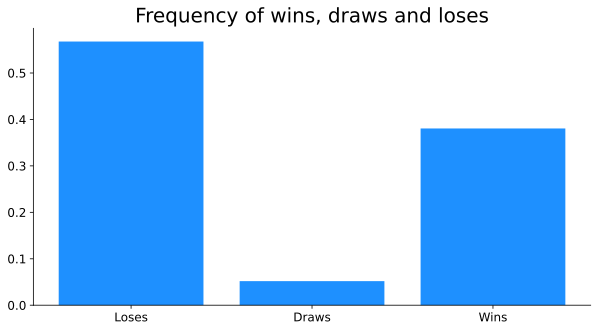

In [15]:
ax = plt.figure(figsize=(10, 5))
plt.bar(unique, counts/len(historic_rewards), color="dodgerblue")
plt.xticks(unique, ('Loses', 'Draws', 'Wins'))
sns.despine(top=True, right=True, left=False, bottom=False)
plt.title('Frequency of wins, draws and loses', fontsize=20)
plt.show()

In [16]:
# # Plot barplot of the rewards
# ax = plt.figure(figsize=(10, 5))
# plt.bar(unique, counts/len(historic_rewards), color="dodgerblue")
# # Set y labels to Loses, Draws and Wins
# plt.xticks(unique, ('Loses', 'Draws', 'Wins'))
# # Remove box unless x-axis
# sns.despine(top=True, right=True, left=True, bottom=False)
# # Remove y ticks
# plt.yticks([])
# # Add text to each bar
# for i, v in enumerate(np.round(counts/len(historic_rewards), 2)):
#     print(v)
#     ax.text(0.25, v/2, str(v), color='black', ha='center')
# # Title
# plt.title('Frequency of wins, draws and loses', fontsize=20)
# plt.show()

## Functions copied from class notebook (not sure they work)

In [33]:
def render_policy_net(model, n_max_steps=500, seed=13):
    frames = []
    env = gym.make('Blackjack-v1', natural=False, sab=False, render_mode='rgb_array')
    # env.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        # frames.append(env.render(mode="rgb_array"))
        probas = model(obs[np.newaxis])
        logits = tf.math.log(probas + tf.keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, info = env.step(action[0, 0].numpy())
        if done:
            break
    env.close()
    return frames

In [34]:
# Now show the animation:

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
frames = render_policy_net(model, seed=42)
plot_animation(frames)